$$ Model \ Inversion \ Attack - SNN - MNIST - Brain Leaks$$

## Necessary Imports

In [1]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.3 MB/s eta 0:00:00


In [2]:
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
from snntorch import spikegen
from snntorch import surrogate
import torch.nn.functional as F
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

## Data Preparation

In [4]:
# Network Architecture
num_inputs = 28*28     # Flatten MNIST Pixels
num_hidden = 3000      #Number of Hidden Layer Neurons
num_outputs = 10

# Training and Data Parameters
batch_size=100
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25      # Number of Time-Steps for Encoding the Static Input
beta = 0.7          # Leakage (Decay) Factor of LIF Neurons

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a transform
transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 107792034.92it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30605278.88it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30129876.78it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15000416.35it/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



# Spiking Neural Network Model

In [6]:
# Define the gradient for the surrogate function fast_sigmoid with a slope of 40.
spike_grad = surrogate.fast_sigmoid(slope=40)

# Define the neural network architecture using PyTorch's nn.Module.
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers and parameters for the network.
        self.fc1 = nn.Linear(num_inputs, num_hidden)  # First fully connected layer.
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)  # Leaky integrate-and-fire neuron model.
        self.fc2 = nn.Linear(num_hidden, num_outputs)  # Second fully connected layer.
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)  # Another Leaky integrate-and-fire neuron model.

    def forward(self, x):
        # Initialize hidden states and output spikes at t=0.
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []  # List to record output spike activity.
        mem2_rec = []  # List to record membrane potential over time.

        # Loop through time steps.
        for step in range(num_steps):
            cur1 = self.fc1(x[step])  # Apply the first layer to the input at the current time step.
            spk1, mem1 = self.lif1(cur1, mem1)  # Compute spikes and membrane potential for the first neuron layer.
            cur2 = self.fc2(spk1)  # Apply the second layer to the first layer's spikes.
            spk2, mem2 = self.lif2(cur2, mem2)  # Compute spikes and membrane potential for the second neuron layer.

            spk2_rec.append(spk2)  # Record the output spikes for this time step.
            mem2_rec.append(mem2)  # Record the membrane potential for this time step.

        # Stack the recorded spikes and membrane potentials along the time dimension and return them.
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Create an instance of the neural network (Net) and move it to the specified device (e.g., GPU).
net = Net().to(device)


In [7]:
# Define functions to print metrics during training loop

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(num_steps, batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, targets_it, train=True)
    print_batch_accuracy(test_spike_data, testtargets_it, train=False)
    print("\n")

The state dictionary containing the pre-trained model's learned parameters is saved in **'MNIST_SNN_Weights_Target'** and can be loaded by running the following cell.

In [11]:
net.load_state_dict(torch.load("MNIST_SNN_Weights_Target",map_location=device)) # Upload "MNIST_SNN_Weights_Target" and then run this cell

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters from "MNIST_SNN_Weights_Target", you don't need to run this cell.

In [ ]:
# Create an Adam optimizer for training the neural network with a specified learning rate and betas.
optimizer = torch.optim.Adam(net.parameters(), lr=5e-5, betas=(0.9, 0.999))

# Instantiate the log softmax function and the negative log-likelihood loss function.
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

# Initialize lists to store training and testing loss values.
loss_hist = []
test_loss_hist = []

# Initialize a counter to keep track of training iterations.
counter = 0

# Outer training loop for epochs
for epoch in range(10):
    minibatch_counter = 0
    data = iter(train_loader) # Create an iterator over the training data.

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator: Convert input data to spike rates for a specified number of time steps.
        spike_data = spikegen.rate(data_it, num_steps=num_steps)


        # Forward pass
        output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform Backpropagation Through Time (BPTT)
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(net.parameters(), 1) # Clip gradients to prevent exploding gradients.

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())



        ## TEST PHASE

        test_data = itertools.cycle(test_loader) # Create an iterator that cycles through the test_loader indefinitely.
        testdata_it, testtargets_it = next(test_data) # Get the next batch of test data and test targets from the cyclic iterator.
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data = spikegen.rate(testdata_it,num_steps=num_steps)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy every 50 iterations
        if counter % 100 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1


Epoch 0, Minibatch 0
Train Set Loss: 57.96674346923828
Test Set Loss: 57.550235748291016
Train Set Accuracy: 0.11
Test Set Accuracy: 0.09


Epoch 0, Minibatch 100
Train Set Loss: 29.47498893737793
Test Set Loss: 30.003192901611328
Train Set Accuracy: 0.81
Test Set Accuracy: 0.79


Epoch 0, Minibatch 200
Train Set Loss: 17.922544479370117
Test Set Loss: 11.298110008239746
Train Set Accuracy: 0.85
Test Set Accuracy: 0.95


Epoch 0, Minibatch 300
Train Set Loss: 9.400015830993652
Test Set Loss: 8.962006568908691
Train Set Accuracy: 0.92
Test Set Accuracy: 0.98


Epoch 0, Minibatch 400
Train Set Loss: 8.822736740112305
Test Set Loss: 11.207664489746094
Train Set Accuracy: 0.92
Test Set Accuracy: 0.91


Epoch 0, Minibatch 500
Train Set Loss: 10.18549919128418
Test Set Loss: 7.80769157409668
Train Set Accuracy: 0.91
Test Set Accuracy: 0.92


Epoch 1, Minibatch 0
Train Set Loss: 9.69498062133789
Test Set Loss: 9.154526710510254
Train Set Accuracy: 0.88
Test Set Accuracy: 0.9


Epoch 1, Miniba

In [ ]:
# torch.save(net.state_dict(), "MNIST_SNN_Weights_Target") # This code saves the model's parameters

## Model Evaluation

In [12]:
# Evaluation
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        spike_data = spikegen.rate(data,num_steps=num_steps)

        output, _ = net(spike_data.view(num_steps, batch_size, -1))
        _, predicted = output.sum(dim=0).max(1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 96.62%


# MI Attacks

## Brain Leaks V1

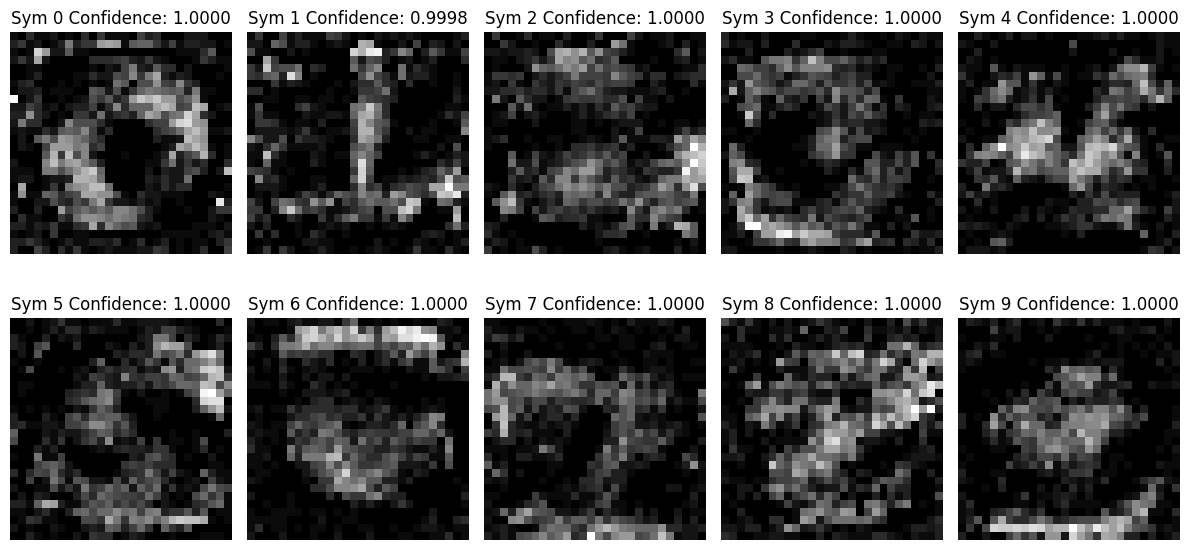

In [43]:
Inverted_Samples_BL1=[] # A list for storing inverted samples of each label

# Create subplots for displaying visualizations.
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

# Loop through each target class
for target_class in range(num_outputs):

    # Initialize spiky input
    spiky_input = torch.zeros((num_steps, 1, num_inputs), requires_grad=True).to(device)

    # Iteratively update spiky input
    for iteration in range(10):

        # Enable gradient computation for spiky input.
        spiky_input.requires_grad_()
        spiky_input.retain_grad()

        # Calculate the cost by maximizing the softmax output for the target class.
        cost = F.softmax(net(spiky_input)[1].squeeze(1), dim=1).mean(dim=0)[target_class]
        cost.backward()

        with torch.no_grad():

            ## 1.

            # Calculate the absolute gradient and normalize it.
            grad = spiky_input.grad

            grad_abs = torch.abs(grad)

            min_val = torch.min(grad_abs)
            max_val = torch.max(grad_abs)
            grad_abs_normalized = (grad_abs - min_val) / (max_val - min_val)

            # Convert Normalized Gradients to Binary

            grad_mask = torch.bernoulli(grad_abs_normalized)



            ## 2. Sign Extraction

            grad_mask_sign = torch.sign(grad) * grad_mask



            ## 3. Overflow-Aware Transformation + Update

            spiky_input = torch.where(spiky_input + grad_mask_sign > 0, torch.tensor(1, dtype=torch.float32), torch.tensor(0, dtype=torch.float32))

    # Calculate the confidence score for the current target class.
    confidence_score = F.softmax(net(spiky_input)[1].squeeze(1), dim=1).mean(dim=0)[target_class]
    Inverted_Samples_BL1.append(spiky_input)

    ## Plotting Phase

    # Determine the subplot's position in the grid.
    row = target_class // 5
    col = target_class % 5

    # Display the decoded spiky input as an image
    axes[row, col].imshow(torch.sum(spiky_input.detach().cpu(), dim=0).view(28, 28), cmap='gray')
    axes[row, col].set_title(f'Sym {target_class} Confidence: {confidence_score:.4f}')
    axes[row, col].axis('off')

# Adjust subplot layout and display the figure.
plt.tight_layout()
plt.show()


In [44]:
Inverted_Samples_BL1 = torch.stack(Inverted_Samples_BL1, dim=0) # Convert the list to a tensor

# torch.save(Inverted_Samples_BL1,'MNIST_SNN_Inverted_BL1')

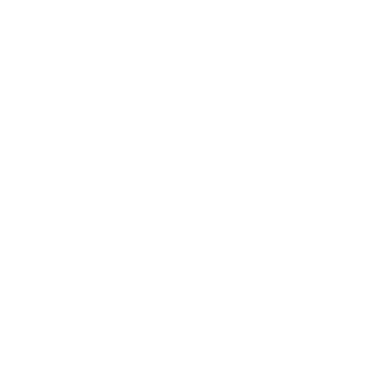

In [47]:
# Visualize a sample spiky input

fig, ax = plt.subplots()
anim = splt.animator(Inverted_Samples_BL1[3].detach().view(25,28,28), fig, ax)
HTML(anim.to_html5_video())

## Brain Leaks V2

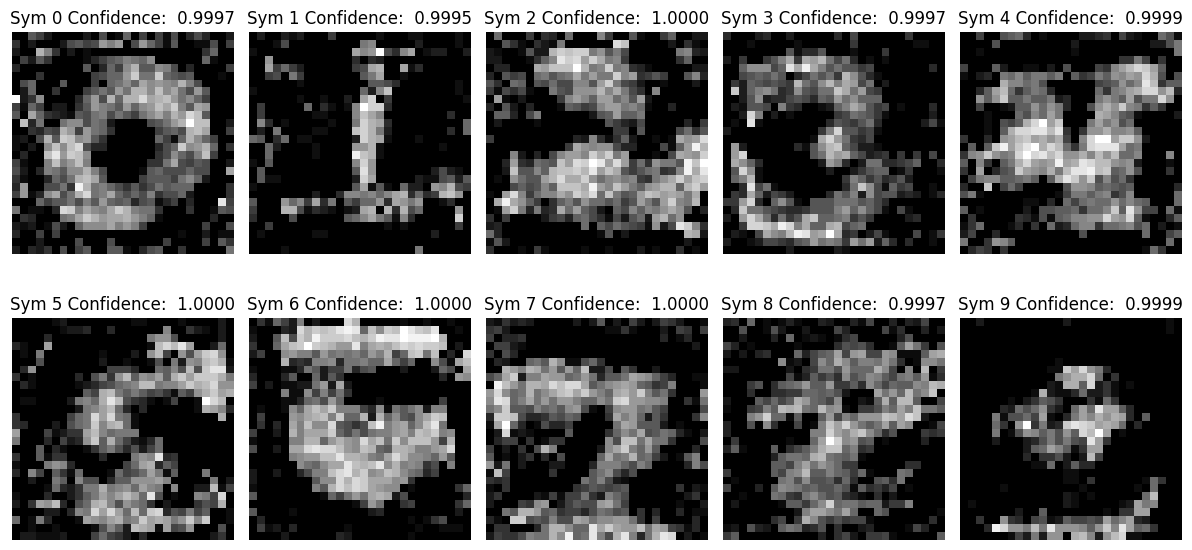

In [33]:
Inverted_Samples_BL2=[] # A list for storing inverted samples of each label

# Create subplots for displaying visualizations.
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)


# Define hyperparameters for the optimization process.

population=7 # Population size for using Natural Evolution Strategies
learning_rate = 1e0 # Gradient descent learning rate
momentum = 0.9 # Momentum
epsilon = 1e-10  # Small constant to prevent division by zero in adaptive learning rate
alpha=0.1 # Controls the rate of accumulation of squared gradients in adaptive learning rate calculations


# Loop through each target class
for target_class in range(num_outputs):

  # Initialize spike probability tensor and create a stack of spiky input tensors.
  spike_probability=torch.zeros((num_steps,1,num_inputs)).to(device)
  spiky_input_stacked=torch.stack([torch.bernoulli(spike_probability) for _ in range(population)]).to(device)

  # Initialize momentum to zero for gradient momentum optimization
  momentum_grad = torch.zeros_like(spike_probability).to(device)

  # Initialize accumulated squared gradients for adaptive learning rate
  squared_grad_sum = torch.zeros_like(spike_probability).to(device)

  # Iteratively update spike probability
  for I in range(10):

    cost_list=[]
    grad_list=[]

    # Iterate through the population of spiky inputs.
    for P in range(population):

      spiky_input=spiky_input_stacked[P]
      spiky_input.requires_grad_()

      # Calculate the cost, including a regularization term.
      cost=1-F.softmax(net(spiky_input)[1].squeeze(1),dim=1).mean(dim=0)[target_class]+0.01*(spiky_input.sum()/spiky_input.numel())
      cost_list.append(cost)
      cost.backward()
      with torch.no_grad():
        grad=spiky_input.grad
        grad_list.append(grad)

    # Aggregate gradients and perform element-wise multiplication with costs.
    grad_aggregated=torch.zeros((num_steps,1,num_inputs)).to(device)


    with torch.no_grad():

      # Iterate through the lists and perform element-wise multiplication
      for g, c in zip(grad_list, cost_list):
          grad_aggregated += (g * c)/sum(cost_list) # Weighted sum of gradients through the population


      # Calculate adaptive learning rates based on squared gradients
      squared_grad_sum += alpha*squared_grad_sum + (1-alpha)*(grad_aggregated**2)
      adaptive_learning_rate = learning_rate / (torch.sqrt(squared_grad_sum) + epsilon)


      # Update spike_probability using the momentum-aided gradient descent
      momentum_grad = momentum * momentum_grad + grad_aggregated
      spike_probability-=adaptive_learning_rate*momentum_grad

      # Clamping and scaling

      spike_probability=torch.where(spike_probability>0,spike_probability,0) # clamp

      maxi=spike_probability.max()
      if maxi>1:
        spike_probability= spike_probability/maxi # scale



      # Generate a stack of spiky inputs based on the updated spike_probability.
      spiky_input_stacked=torch.stack([torch.bernoulli(spike_probability) for _ in range(population)])

  # Calculate the confidence score for the current target class using the one of the generated spiky inputs
  confidence_score=F.softmax(net(spiky_input_stacked[0])[1].squeeze(1),dim=1).mean(dim=0)[target_class]
  Inverted_Samples_BL2.append(spike_probability)


  ## Plotting Phase

  row = target_class // 5
  col = target_class % 5
  axes[row, col].imshow(torch.sum(spiky_input_stacked[0].detach().cpu(),dim=0).view(28,28),cmap='gray')
  axes[row, col].set_title(f'Sym {target_class} Confidence: {confidence_score: .4f}')
  axes[row, col].axis('off')

plt.tight_layout()
plt.show()



In [35]:
Inverted_Samples_BL2 = torch.stack(Inverted_Samples_BL2, dim=0) # Convert the list to a tensor

# torch.save(Inverted_Samples_BL2,'MNIST_SNN_Inverted_BL2')

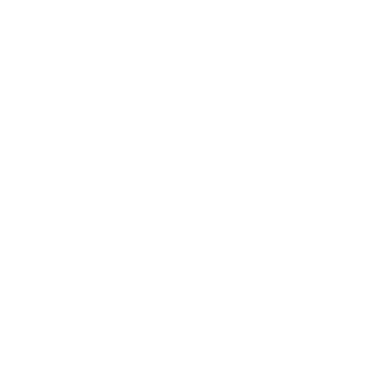

In [42]:
# Visualize a sample spiky input

fig, ax = plt.subplots()
anim = splt.animator(torch.bernoulli(Inverted_Samples_BL2[3]).detach().view(25,28,28), fig, ax)
HTML(anim.to_html5_video())